In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pymc3 as pm
import numpy as np

In [2]:
tosses = np.random.randint(0, 2, 30)

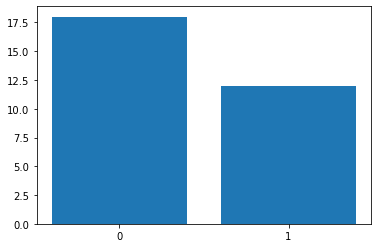

In [4]:
plt.bar(np.unique(tosses, return_counts = True)[0], np.unique(tosses, return_counts = True)[1])
plt.xticks([0, 1]);

In [5]:
import scipy.stats as stats

In [6]:
probs = [0, 0.25, 0.5, 0.75, 1]

### Binomial Distribution: Our Likelihood

In general, if the random variable X follows the binomial distribution with parameters n ∈ ℕ and p ∈ [0,1], we write X ~ B(n, p). The probability of getting exactly k successes in n independent Bernoulli trials is given by the probability mass function:

$$\displaystyle f(k,n,p)=\Pr(k;n,p)=\Pr(X=k)={\binom {n}{k}}p^{k}(1-p)^{n-k}$$

for k = 0, 1, 2, ..., n, where

$\displaystyle {\binom {n}{k}}={\frac {n!}{k!(n-k)!}}$


is the binomial coefficient, hence the name of the distribution. 

In [7]:
n = 1
xs = np.arange(0, n+1)
stats.binom(1, 0.25).pmf(xs)

array([0.75, 0.25])

In [8]:
def coin_simulator(n, p):
    xs = np.arange(0, n+1)
    ys = stats.binom(n, p).pmf(xs)
    plt.bar(xs, ys)
    plt.title(f'Probability of getting x heads out of {n} throws')

In [9]:
from ipywidgets import interact
import ipywidgets as widgets

In [10]:
interact(coin_simulator, n = widgets.IntSlider(min = 1, max = 100, step = 1), p = widgets.FloatSlider(min = 0, max = 1, step = 0.1))

interactive(children=(IntSlider(value=1, description='n', min=1), FloatSlider(value=0.0, description='p', max=…

<function __main__.coin_simulator(n, p)>

### Beta Distribution: Our Prior

The probability density function (pdf) of the beta distribution, for 0 ≤ x ≤ 1, and shape parameters α, β > 0, is a power function of the variable x and of its reflection (1 − x) as follows:

$$\displaystyle {\begin{aligned}f(x;\alpha ,\beta )&=\mathrm {constant} \cdot x^{\alpha -1}(1-x)^{\beta -1}\\[3pt]&={\frac {x^{\alpha -1}(1-x)^{\beta -1}}{\displaystyle \int _{0}^{1}u^{\alpha -1}(1-u)^{\beta -1}\,du}}\\[6pt]&={\frac {\Gamma (\alpha +\beta )}{\Gamma (\alpha )\Gamma (\beta )}}\,x^{\alpha -1}(1-x)^{\beta -1}\\[6pt]&={\frac {1}{\mathrm {B} (\alpha ,\beta )}}x^{\alpha -1}(1-x)^{\beta -1}\end{aligned}}$$

where Γ(z) is the gamma function. The beta function, $\displaystyle \mathrm {B}$, is a normalization constant to ensure that the total probability is 1. In the above equations x is a realization—an observed value that actually occurred—of a random process X.




In [11]:
def beta_plotter(a, b):
    x = np.linspace(0, 1, 100)
    y = stats.beta(a, b).pdf(x)
    plt.plot(x, y)

In [12]:
interact(beta_plotter, a = widgets.FloatSlider(min = 0, max = 3, step = 0.1), b = widgets.FloatSlider(min = 0, max = 3, step = 0.1))

interactive(children=(FloatSlider(value=0.0, description='a', max=3.0), FloatSlider(value=0.0, description='b'…

<function __main__.beta_plotter(a, b)>

We use Beta and Binomial here due to conjugate priors; others here https://en.wikipedia.org/wiki/Conjugate_prior.

### Computing the Posterior

$$p(\theta | y) \propto p(y | \theta)p(\theta) $$

$$p(\theta | y) \propto binom \times beta$$

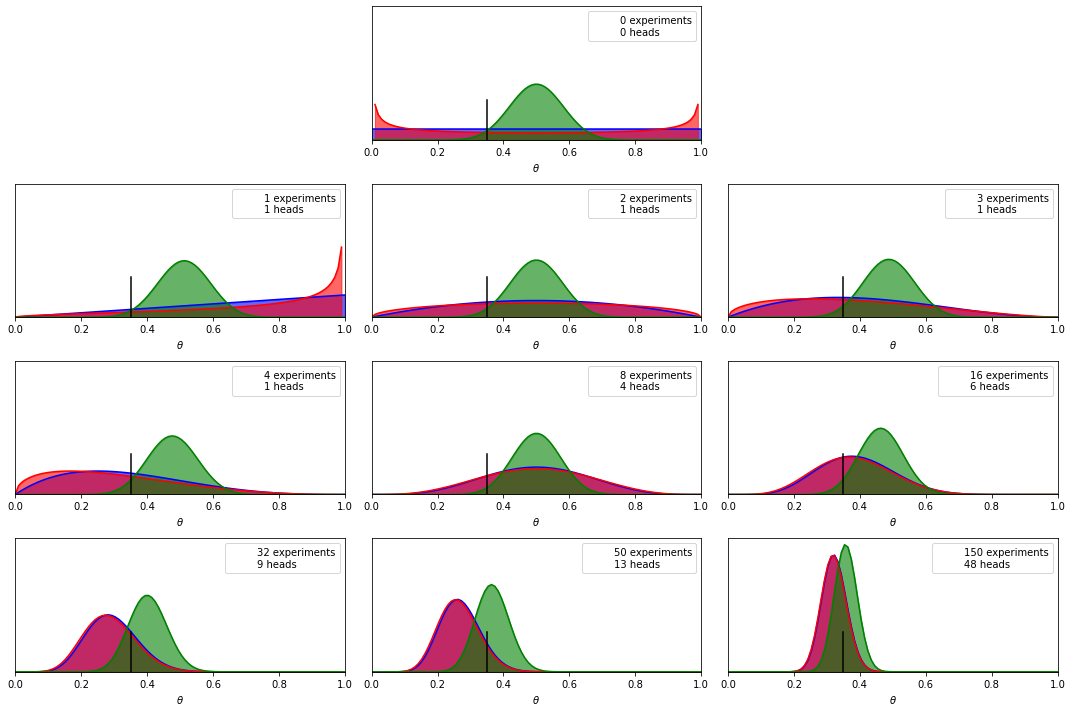

In [13]:
theta_real = 0.35
trials = [0, 1, 2, 3, 4, 8, 16, 32, 50, 150]
data = [0, 1, 1, 1, 1, 4, 6, 9, 13, 48]

beta_params = [(1, 1), (0.5, 0.5), (20, 20)]
dist = stats.beta
x = np.linspace(0, 1, 100)
plt.figure(figsize = (15, 10))
for idx, N in enumerate(trials):
    if idx == 0:
        plt.subplot(4,3, 2)
    else:
        plt.subplot(4,3, idx+3)
    y = data[idx]
    for (a_prior, b_prior), c in zip(beta_params, ('b', 'r', 'g')):
        p_theta_given_y = dist.pdf(x, a_prior + y, b_prior + N - y)
        plt.plot(x, p_theta_given_y, c)
        plt.fill_between(x, 0, p_theta_given_y, color=c, alpha=0.6)

    plt.axvline(theta_real, ymax=0.3, color='k')
    plt.plot(0, 0, label="{:d} experiments\n{:d} heads".format(N, y), alpha=0)
    plt.xlim(0,1)
    plt.ylim(0,12)
    plt.xlabel(r'$\theta$') 
    plt.legend()
    plt.gca().axes.get_yaxis().set_visible(False)
plt.tight_layout()

### PyMC3 Intro

In [14]:
tosses = np.random.binomial(1, 0.2, 300)#np.random.randint(0, 2, 300)

In [15]:
with pm.Model() as coin_model:
    p_prior = pm.Beta('theta', alpha = 1, beta = 1)
    like = pm.Bernoulli('likelihood', p = p_prior, 
                       observed = tosses)

In [16]:
with coin_model:
    step = pm.Metropolis()
    coin_trace = pm.sample(2000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.
The number of effective samples is smaller than 25% for some parameters.


/Users/jacobkoehler/opt/anaconda3/envs/for_ds/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


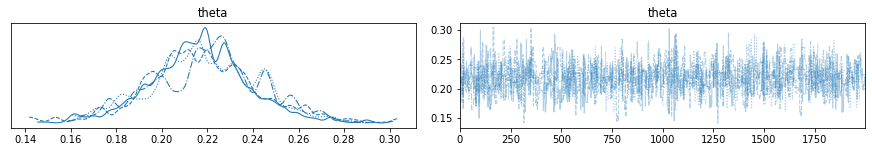

In [17]:
pm.traceplot(coin_trace);
plt.show();

/Users/jacobkoehler/opt/anaconda3/envs/for_ds/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'theta'}>

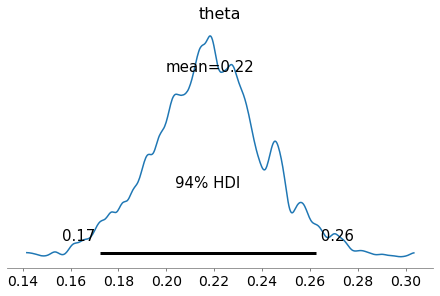

In [18]:
pm.plot_posterior(coin_trace)

/Users/jacobkoehler/opt/anaconda3/envs/for_ds/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'theta'}>

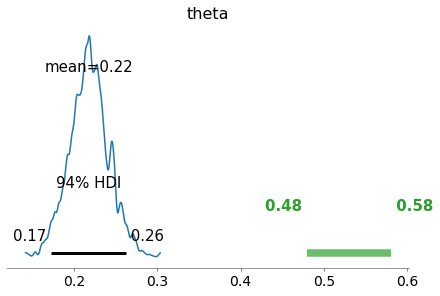

In [19]:
pm.plot_posterior(coin_trace, rope = [0.48, 0.58])

/Users/jacobkoehler/opt/anaconda3/envs/for_ds/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'theta'}>

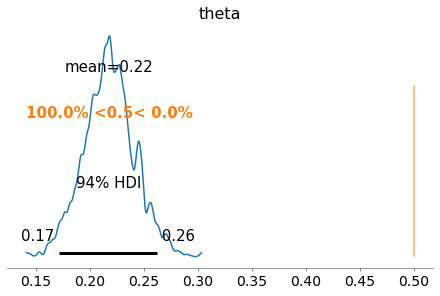

In [20]:
pm.plot_posterior(coin_trace, ref_val = 0.5)

### Linear Regression

$$y \text{~} N(\mu = \alpha + \beta x, \sigma = \epsilon)$$

Our data $y$ is gaussian with mean $\alpha + \beta x$ and standard deviation $\epsilon$.  

**Select Priors**

- $\alpha, \beta$ - N(mean, std)
- $\epsilon$ - U(0, $h_s$)


In [21]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

data = dict(x=x, y=y)

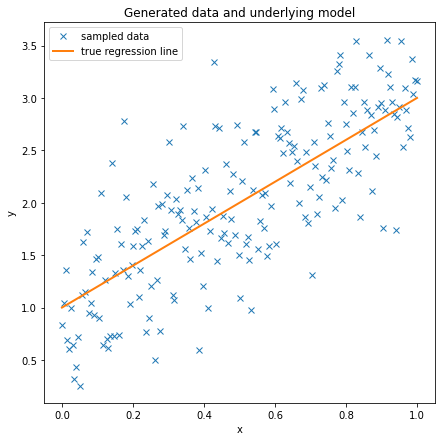

In [22]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

In [23]:
with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('Intercept', 0, sigma=20)
    x_coeff = pm.Normal('x', 0, sigma=20)

    # Define likelihood
    likelihood = pm.Normal('y', mu=intercept + x_coeff * x,
                        sigma=sigma, observed=y)

    # Inference!
    trace = pm.sample(3000, cores=2) # draw 3000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 7 seconds.


/Users/jacobkoehler/opt/anaconda3/envs/for_ds/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
<ipython-input-24-a4c4099afaff>:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout();


<Figure size 504x504 with 0 Axes>

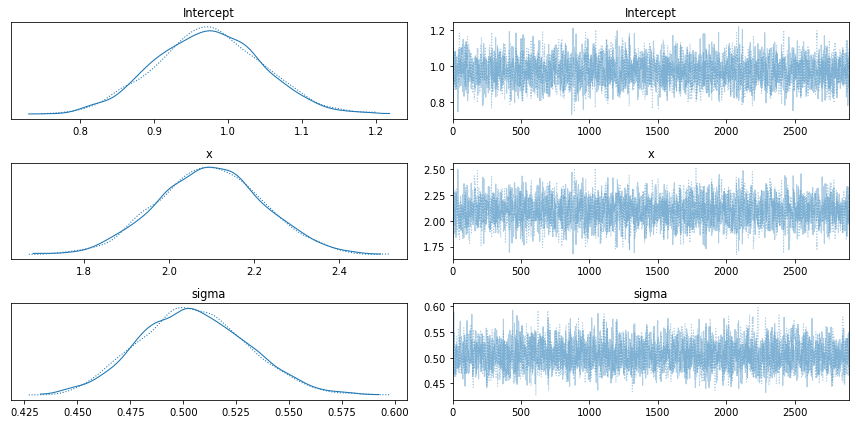

In [24]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace[100:])
plt.tight_layout();

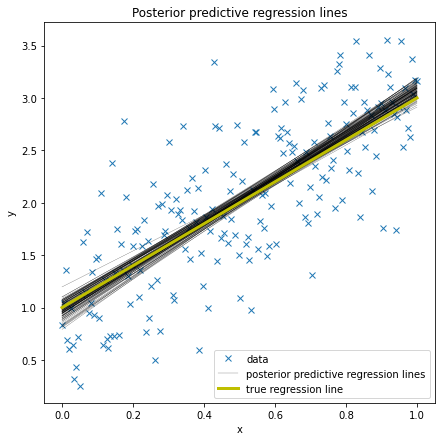

In [25]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, 'x', label='data')
pm.plot_posterior_predictive_glm(trace, samples=100,
                              label='posterior predictive regression lines')
plt.plot(x, true_regression_line, label='true regression line', lw=3., c='y')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');

### KNN Example

In [26]:
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [27]:
penguins = sns.load_dataset('penguins')

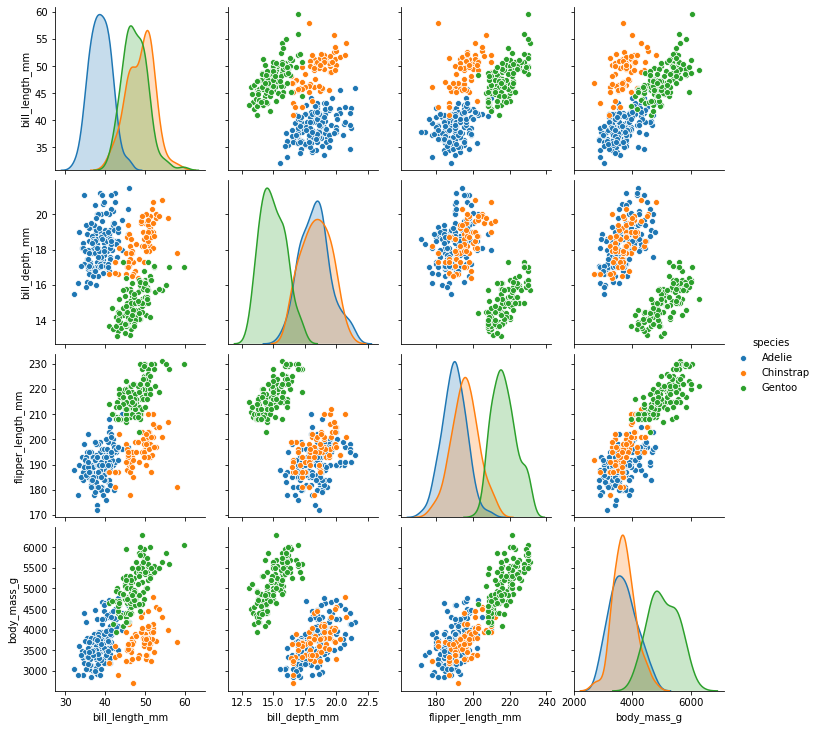

In [28]:
sns.pairplot(penguins, hue = 'species')

In [29]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [30]:
penguins.dropna(inplace = True)

In [62]:
X = penguins.iloc[:, 1:]
y = penguins.species

In [63]:
import pandas as pd

In [64]:
X = pd.get_dummies(X)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [66]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [67]:
knn.score(X_train, y_train)

0.8594377510040161

In [68]:
knn.score(X_test, y_test)

0.8214285714285714

In [69]:
y.value_counts()

Adelie       146
Gentoo       119
Chinstrap     68
Name: species, dtype: int64

In [70]:
146/(146 + 119 + 68)

0.43843843843843844

In [71]:
#scale the data
from sklearn.preprocessing import StandardScaler

In [72]:
sscaler = StandardScaler()

In [73]:
X_train_scaled = sscaler.fit_transform(X_train)
X_test_scaled = sscaler.transform(X_test)

In [74]:
knn2 = KNeighborsClassifier()

In [75]:
knn2.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [76]:
knn2.score(X_train_scaled, y_train)

1.0

In [77]:
knn2.score(X_test_scaled, y_test)

0.9880952380952381

In [78]:
from sklearn.model_selection import GridSearchCV

In [79]:
params = {'n_neighbors': [2, 5, 10, 20, 30]}

In [80]:
grid = GridSearchCV(knn2, param_grid=params)

In [81]:
grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 5, 10, 20, 30]})

In [82]:
grid.score(X_train_scaled, y_train)

1.0

In [83]:
grid.score(X_test_scaled, y_test)

0.9761904761904762

In [84]:
grid.best_params_

{'n_neighbors': 2}